In [1]:
import gym
import tensorflow as tf


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [3]:
import numpy as np
import pandas as pd

In [4]:
env = gym.make("Taxi-v2")

In [5]:
# def create_net(input_state, variable_scope, layer_list, trainable, action_num):
#     with tf.variable_scope(variable_scope):
#         w_initialiser = tf.random_normal_initializer(mean=0., stddev=0.01)
# #         layer1 = tf.layers.Dense(units=500, activation=tf.nn.relu,
# #                                  name="layer", trainable=trainable,
# #                                 kernel_initializer=w_initialiser)
# #         layer_list.append(layer1)
# #         layer1_output = layer1(input_state)
# #         layer2 = tf.layers.Dense(units=5, activation=tf.nn.relu,
# #                                  name="layer", trainable=trainable)
# #         layer_list.append(layer2)
# #         layer2_output = layer2(layer1_output)
#         output_layer = tf.layers.Dense(units=action_num, name="layer", 
#                                        trainable=trainable, kernel_initializer=w_initialiser,
#                                        activation=None
#                                       )
#         layer_list.append(output_layer)
#         output = output_layer(input_state)

#         return output
    
def create_net(input_state, variable_scope, variable_list, trainable):
    with tf.variable_scope(variable_scope):
        
        weights_1 = tf.get_variable(name="w1",
                                    initializer=tf.random_uniform([env.observation_space.n, env.action_space.n],0,0.01),
                                    trainable=trainable
                                   )
#         variable_list.append(weights_1)
#         weights_2 = tf.get_variable(name="w2",
#                                     initializer=tf.random_uniform([10, env.action_space.n],0,0.01)
#                                    )
#         bias = tf.get_variable(name="b1",
#                                shape=[10],
#                                initializer=tf.constant_initializer(0.01)
#                               )
#         layer1_output = tf.nn.relu(tf.matmul(input_state, weights_1))
        output = tf.matmul(input_state, weights_1)
        
        return output

In [6]:
def copy_net(dest_list, src_list, sess):
    for predict_variable, target_variable in zip(src_list, dest_list):
        assign_op = tf.assign(ref=target_variable, value=predict_variable)
        sess.run(assign_op)

## Create the neural network
---

In [7]:
tf.reset_default_graph()

In [8]:
predict_input_state_tf = tf.placeholder(shape=(None, env.observation_space.n), dtype= tf.float32, name="predict_input_state")
target_input_state_tf = tf.placeholder(shape=(None, env.observation_space.n), dtype=tf.float32, name="target_input_state")


In [9]:
predict_variable_list = []
predict_q_values_tf = create_net(predict_input_state_tf, variable_scope="predict_net",
                                 variable_list=predict_variable_list, trainable=True)

predict_action_tf = tf.argmax(predict_q_values_tf, axis=1)

In [10]:
target_variable_list = []
target_q_values_tf = create_net(target_input_state_tf, variable_scope="target_net",
                                 variable_list=target_variable_list, trainable=False)

In [11]:
y_tf = tf.placeholder(shape=(None, env.action_space.n), dtype=tf.float32)

with tf.variable_scope("loss"):
#     loss_tf = tf.losses.mean_squared_error(labels=y_tf, predictions=predict_q_values_tf)

    loss_tf = tf.reduce_sum(tf.squared_difference(y_tf, predict_q_values_tf))
with tf.variable_scope("train"):
    train_op = tf.train.GradientDescentOptimizer(0.3).minimize(loss_tf)

## Set up hyperparameters

In [12]:
max_random_probability = 1.0
min_random_probability = 0
mem_size = 3000
update_epoches = 100
batch_size = 32
gamma = 0.99
one_hot_state = np.identity(env.observation_space.n)

In [13]:
init_op = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init_op)

## Start training the network

In [14]:
loss_list = []
reward_list = []
steps_list = []

episode_num = 1000
all_step_counter = 0
random_probability_distribution = np.linspace(max_random_probability, min_random_probability, episode_num * 0.8)


for i in range(episode_num):
    done = False
    episode_reward = 0
    current_state = env.reset()
    step_counter = 0
    random_probability = random_probability_distribution[i] if i < len(random_probability_distribution) else min_random_probability
    while step_counter < 100: # If agent cannot find the solution in 50 steps reset the environment
        [action], predict_q_values = sess.run([predict_action_tf, predict_q_values_tf],
                                              feed_dict={
                                                  predict_input_state_tf: one_hot_state[current_state: current_state + 1]
                                              })        
        
        if np.random.uniform() <= random_probability:
            # Randomly explore the world
            action = env.action_space.sample()
        
        # Execute the action and observe the reward
        next_state, reward, done, info = env.step(action)

        # If we don't use the target network
        next_q_values = sess.run(predict_q_values_tf, feed_dict={
            predict_input_state_tf: one_hot_state[next_state: next_state + 1]
        })

        # Pick the max q value for next state
        max_next_q_value = np.max(next_q_values)
        # Take the other actions q values
        y = predict_q_values
        # Update the right we performed only
        y[0, action] = reward + gamma * max_next_q_value

        # Learn
        _, loss = sess.run([train_op, loss_tf], feed_dict={
            predict_input_state_tf: one_hot_state[current_state: current_state + 1],
            y_tf: y
        })

        loss_list.append(loss)
        
        current_state = next_state
        
        episode_reward += reward
        step_counter += 1
        
        if i > episode_num - 5:
            env.render()
            print(loss)
        
        if done == True:
            break
    
    
    reward_list.append(episode_reward)
    steps_list.append(step_counter)
    
    print("Episode: {0},  step: {1}, random: {2}".format(i, step_counter, random_probability))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


Episode: 0,  step: 100, random: 1.0
Episode: 1,  step: 100, random: 0.9987484355444305
Episode: 2,  step: 100, random: 0.9974968710888611
Episode: 3,  step: 100, random: 0.9962453066332916
Episode: 4,  step: 100, random: 0.9949937421777222
Episode: 5,  step: 100, random: 0.9937421777221527
Episode: 6,  step: 100, random: 0.9924906132665833
Episode: 7,  step: 100, random: 0.9912390488110138
Episode: 8,  step: 100, random: 0.9899874843554443
Episode: 9,  step: 100, random: 0.9887359198998749
Episode: 10,  step: 100, random: 0.9874843554443054
Episode: 11,  step: 100, random: 0.986232790988736
Episode: 12,  step: 100, random: 0.9849812265331664
Episode: 13,  step: 100, random: 0.983729662077597
Episode: 14,  step: 100, random: 0.9824780976220275
Episode: 15,  step: 100, random: 0.981226533166458
Episode: 16,  step: 100, random: 0.9799749687108886
Episode: 17,  step: 100, random: 0.9787234042553191
Episode: 18,  step: 100, random: 0.9774718397997497
Episode: 19,  step: 100, random: 0.97622

Episode: 158,  step: 100, random: 0.8022528160200251
Episode: 159,  step: 83, random: 0.8010012515644556
Episode: 160,  step: 100, random: 0.799749687108886
Episode: 161,  step: 100, random: 0.7984981226533167
Episode: 162,  step: 100, random: 0.7972465581977471
Episode: 163,  step: 100, random: 0.7959949937421777
Episode: 164,  step: 100, random: 0.7947434292866082
Episode: 165,  step: 100, random: 0.7934918648310387
Episode: 166,  step: 72, random: 0.7922403003754693
Episode: 167,  step: 100, random: 0.7909887359198999
Episode: 168,  step: 100, random: 0.7897371714643304
Episode: 169,  step: 100, random: 0.7884856070087609
Episode: 170,  step: 100, random: 0.7872340425531915
Episode: 171,  step: 100, random: 0.785982478097622
Episode: 172,  step: 100, random: 0.7847309136420526
Episode: 173,  step: 100, random: 0.7834793491864831
Episode: 174,  step: 100, random: 0.7822277847309136
Episode: 175,  step: 100, random: 0.7809762202753442
Episode: 176,  step: 100, random: 0.77972465581977

Episode: 314,  step: 69, random: 0.6070087609511889
Episode: 315,  step: 36, random: 0.6057571964956194
Episode: 316,  step: 100, random: 0.60450563204005
Episode: 317,  step: 39, random: 0.6032540675844806
Episode: 318,  step: 36, random: 0.6020025031289111
Episode: 319,  step: 100, random: 0.6007509386733416
Episode: 320,  step: 55, random: 0.5994993742177722
Episode: 321,  step: 70, random: 0.5982478097622028
Episode: 322,  step: 100, random: 0.5969962453066333
Episode: 323,  step: 80, random: 0.5957446808510638
Episode: 324,  step: 65, random: 0.5944931163954943
Episode: 325,  step: 34, random: 0.5932415519399249
Episode: 326,  step: 92, random: 0.5919899874843555
Episode: 327,  step: 45, random: 0.590738423028786
Episode: 328,  step: 11, random: 0.5894868585732165
Episode: 329,  step: 23, random: 0.588235294117647
Episode: 330,  step: 27, random: 0.5869837296620776
Episode: 331,  step: 47, random: 0.5857321652065082
Episode: 332,  step: 17, random: 0.5844806007509387
Episode: 333,

Episode: 471,  step: 30, random: 0.4105131414267834
Episode: 472,  step: 22, random: 0.409261576971214
Episode: 473,  step: 39, random: 0.4080100125156445
Episode: 474,  step: 16, random: 0.4067584480600751
Episode: 475,  step: 25, random: 0.4055068836045056
Episode: 476,  step: 13, random: 0.4042553191489362
Episode: 477,  step: 26, random: 0.4030037546933667
Episode: 478,  step: 20, random: 0.4017521902377972
Episode: 479,  step: 45, random: 0.4005006257822278
Episode: 480,  step: 25, random: 0.39924906132665827
Episode: 481,  step: 31, random: 0.3979974968710889
Episode: 482,  step: 14, random: 0.39674593241551936
Episode: 483,  step: 13, random: 0.39549436795994997
Episode: 484,  step: 14, random: 0.39424280350438046
Episode: 485,  step: 14, random: 0.39299123904881095
Episode: 486,  step: 31, random: 0.39173967459324155
Episode: 487,  step: 16, random: 0.39048811013767204
Episode: 488,  step: 23, random: 0.38923654568210264
Episode: 489,  step: 20, random: 0.38798498122653313
Epis

Episode: 628,  step: 15, random: 0.214017521902378
Episode: 629,  step: 17, random: 0.21276595744680848
Episode: 630,  step: 21, random: 0.21151439299123898
Episode: 631,  step: 11, random: 0.21026282853566958
Episode: 632,  step: 14, random: 0.20901126408010007
Episode: 633,  step: 26, random: 0.20775969962453067
Episode: 634,  step: 14, random: 0.20650813516896116
Episode: 635,  step: 14, random: 0.20525657071339176
Episode: 636,  step: 22, random: 0.20400500625782225
Episode: 637,  step: 16, random: 0.20275344180225274
Episode: 638,  step: 18, random: 0.20150187734668334
Episode: 639,  step: 17, random: 0.20025031289111384
Episode: 640,  step: 18, random: 0.19899874843554444
Episode: 641,  step: 15, random: 0.19774718397997493
Episode: 642,  step: 13, random: 0.19649561952440553
Episode: 643,  step: 16, random: 0.19524405506883602
Episode: 644,  step: 21, random: 0.1939924906132665
Episode: 645,  step: 11, random: 0.1927409261576971
Episode: 646,  step: 18, random: 0.191489361702127

Episode: 788,  step: 14, random: 0.013767209011264048
Episode: 789,  step: 16, random: 0.012515644555694538
Episode: 790,  step: 13, random: 0.01126408010012514
Episode: 791,  step: 12, random: 0.01001251564455563
Episode: 792,  step: 8, random: 0.008760951188986232
Episode: 793,  step: 10, random: 0.007509386733416723
Episode: 794,  step: 12, random: 0.006257822277847325
Episode: 795,  step: 17, random: 0.005006257822277815
Episode: 796,  step: 14, random: 0.003754693366708306
Episode: 797,  step: 17, random: 0.0025031289111389077
Episode: 798,  step: 14, random: 0.0012515644555693983
Episode: 799,  step: 14, random: 0.0
Episode: 800,  step: 16, random: 0
Episode: 801,  step: 14, random: 0
Episode: 802,  step: 18, random: 0
Episode: 803,  step: 18, random: 0
Episode: 804,  step: 12, random: 0
Episode: 805,  step: 8, random: 0
Episode: 806,  step: 12, random: 0
Episode: 807,  step: 11, random: 0
Episode: 808,  step: 11, random: 0
Episode: 809,  step: 13, random: 0
Episode: 810,  step: 

## Evaluate the performance

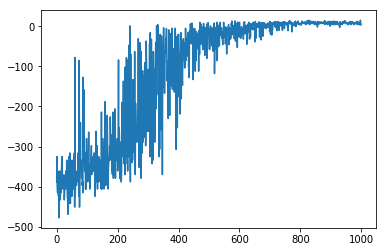

In [15]:
plt.plot(reward_list)

In [16]:
np.mean(reward_list)

-110.787

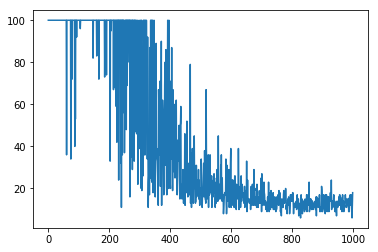

In [17]:
plt.plot(steps_list)

In [18]:
np.mean(steps_list)

43.743

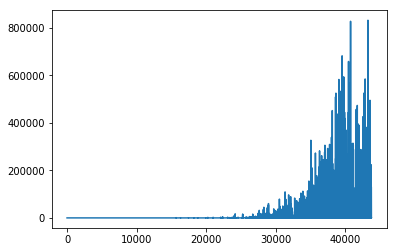

In [19]:
plt.plot(loss_list)

## Evaluate with the real q table

In [20]:
import pickle

q_table = pickle.load(open("obj/q_table.pkl", "rb"))

Using the `DQN` predicts the whole table

In [21]:
predict_q_table = sess.run(predict_q_values_tf, feed_dict={predict_input_state_tf: one_hot_state})

In [22]:
np.mean(np.absolute(predict_q_table - q_table))

161.66234543985843